In [150]:
import json
import math
import os.path
import sys
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from IPython.display import HTML, Image, clear_output, display
from torch.autograd import Variable
from tqdm import tqdm

import spacy

sys.path.append('..')

ModuleNotFoundError: No module named 'spacy'

In [2]:
import config
import data
import model_IG
import utils

/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%reload_ext autoreload
%autoreload 2

## Paths, parameters, etc.

In [69]:
# which GPU device to use?
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# path to pretrained model
MODEL_FILE = '../logs/2017-08-04_00.55.19.pth'

# TSV file to write attributions 
ATTRS_TSV = '/scratch/pramodkm/acl18/vqa/tsv/attrs.tsv'

# HTML file to pretty display attributions
# The folder containing the images is assumed to be named "val" 
# and be in the same directory as this HTML
ATTRS_HTML = '/scratch/pramodkm/acl18/vqa/attrs.html'

# Number of steps in Riemann integral computation for Integrated Gradients
NUM_STEPS = 2000

# Sample size of dataset to use in all computations of this notebooks
MAX_NUM_BATCHES = 50 # corresponds to 6400 inputs

# File (EPS format) for writing the overstability curve
OVERSTABILITY_CURVE_FILE = '/scratch/pramodkm/acl18/vqa/overstability.eps'

In [5]:
# Load pretrained model
log = torch.load(MODEL_FILE)
tokens = len(log['vocab']['question']) + 1

net = torch.nn.DataParallel(model_IG.Net(tokens))
net.load_state_dict(log['weights'])

../model_IG.py:95: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(w)
../model_IG.py:91: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
../model_IG.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


In [6]:
# Load vocabulary
with open(config.vocabulary_path, 'r') as fd:
    vocab_json = json.load(fd)
reverse_vocab_question = dict(
    [(v, k) for k, v in vocab_json['question'].items()])
reverse_vocab_answer = dict([(v, k) for k, v in vocab_json['answer'].items()])

In [7]:
# Extract embedding matrix for question words
question_emb_lookup = log['weights']['module.text.embedding.weight']
embedding = nn.Embedding(
    question_emb_lookup.shape[0], question_emb_lookup.shape[1], padding_idx=0)
embedding.weight.data = question_emb_lookup

In [8]:
# Load validation data
val_loader = data.get_loader(val=True)
LOADER = val_loader
PREFIX = "val"

In [9]:
# Image index dict
reverse_coco_idxs = dict(
    [(v, k) for k, v in val_loader.dataset.coco_id_to_index.items()])

In [10]:
def get_answer(a):
    """ Get the answer that at least 3 turkers have agreed on """
    indices = torch.nonzero(a >= 3)
    if len(indices) == 0:
        return ''
    return '|'.join([reverse_vocab_answer[int(index)] for index in indices])

In [ ]:
# Setting up a few items
if not os.path.isdir(os.path.dirname(ATTRS_TSV)):
    os.makedirs(os.path.dirname(ATTRS_TSV))

var_params = {
    'volatile': True,
    'requires_grad': False,
}

# number of batches for the integral summation for computing attributions
num_batches_ig = int(np.ceil(NUM_STEPS/val_loader.batch_size))

## Compute attributions

In [41]:
padding_embedding = embedding.weight.data[0, :]


def scale_input(q_emb, num_batches=1):
    """ Create scaled versions of input and stack along batch dimension
    q_emb shape = (q_length, emb_dim)
    """
    num_points = config.batch_size*num_batches
    scale = 1.0/num_points
    step = (q_emb.unsqueeze(0) -
            padding_embedding.unsqueeze(0).unsqueeze(0)) * scale
    ans = torch.cat([torch.add(padding_embedding, step*i)
                     for i in range(num_points)], dim=0)
    return ans, step.squeeze()

In [136]:
def compute_attributions(q_emb, q_len, v, idx, num_batches=5, answer=None):
    """ compute attributions for all examples in a given batch """
    ans = ''
    for batch_i in range(config.batch_size):
        scaled_q_emb, step = scale_input(
            q_emb[batch_i, :, :], num_batches=num_batches)
        diff = 0
        total_grads = 0
        for j in range(num_batches):
            repeated_q_len = (torch.torch.ones_like(q_len)*q_len[batch_i])
            repeated_v = (torch.ones_like(v)*v[batch_i])
            batch_scaled_q_emb = scaled_q_emb[j*config.batch_size:(
                j+1)*config.batch_size]
            with torch.autograd.set_grad_enabled(True):
                scaled_answer, gradients = net(
                    repeated_v, batch_scaled_q_emb, repeated_q_len, compute_gradient=True, ans_index=int(answer[batch_i]))
            # at this point, shape(gradients) = 128 x 23 x 300
            total_grads += torch.sum(gradients, dim=0)
            if j == 0:
                diff -= scaled_answer[0, answer[batch_i]]
                baseline_softmax = scaled_answer[0, :]
            if j == num_batches - 1:
                diff += scaled_answer[-1, answer[batch_i]]
        del scaled_q_emb, repeated_q_len, repeated_v, batch_scaled_q_emb, gradients
        attributions = torch.sum(total_grads * step, dim=1)
        area = torch.sum(attributions, dim=0)
        print('--------------------------')
        print(('diff: ', float(diff)))
        print(('area: ', float(area)))
        if abs(float(diff) - float(area)) > 0.1:
            print(('WARNING: attribution sanity check not matching up!! Diff = ', abs(
                float(diff) - float(area))))

        predicted_answer = reverse_vocab_answer[int(answer[batch_i])]
        correct_answer = get_answer(a[batch_i, :])
        _, baseline_topk_answers = baseline_softmax.topk(1)
        baseline_topk_answers = ', '.join(
            [reverse_vocab_answer[int(i)] for i in baseline_topk_answers])

        if baseline_topk_answers[0] == predicted_answer:
            attributions = attributions*0

        #print('Predicted answer: ', predicted_answer)
        #print('Baseline top k answers : ', ' | '.join(baseline_topk_answers))
        #print('Prediction is correct?: ', int(acc[batch_i]))
        #print('Image ID: ', val_loader.dataset.coco_ids[int(idx[batch_i])])
        question_attrs = []
        for j, w in enumerate(q[batch_i, :]):
            if int(w) != 0:
                #print(reverse_vocab_question[int(w)], ': ', float(attributions[j]))
                question_attrs.append(
                    '|'.join([str(reverse_vocab_question[int(w)]), str(float(attributions[j]))]))
        tsv_string = ['||'.join(question_attrs), baseline_topk_answers, predicted_answer, correct_answer, str(
            int(acc[batch_i])), str(val_loader.dataset.coco_ids[int(idx[batch_i])])]
        ans += '\t'.join(tsv_string) + '\n'
    return ans

In [137]:
# Script to compute attributions for a fixed number of batches
net.train()
accs = []
num_batches = 0
with open(ATTRS_TSV, 'w') as outf:
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:

        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        _, answer = out.data.cpu().max(dim=1)

        attrs_tsv_string = compute_attributions(
            q_emb, q_len, v, idx, num_batches=num_batches_ig, answer=answer)

        outf.write(attrs_tsv_string)
        outf.flush()

        accs.append(np.array(acc.view(-1)))

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

accs = list(np.concatenate(accs, dim=0))



val E000:   0% 0/950 [00:00<?, ?it/s]../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)
../model_IG.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = torch.nn.functional.softmax(answer)


--------------------------
('diff: ', 0.18070226907730103)
('area: ', 0.18094158172607422)
--------------------------
('diff: ', 0.5486360788345337)
('area: ', 0.5488159656524658)
--------------------------
('diff: ', 0.12886281311511993)
('area: ', 0.12885290384292603)
--------------------------
('diff: ', 0.19869333505630493)
('area: ', 0.1986498236656189)
--------------------------
('diff: ', 0.6828103065490723)
('area: ', 0.6830248236656189)
--------------------------
('diff: ', 0.15882307291030884)
('area: ', 0.15880736708641052)
--------------------------
('diff: ', 0.4037765860557556)
('area: ', 0.4037899971008301)
--------------------------
('diff: ', 0.3646804094314575)
('area: ', 0.36466723680496216)
--------------------------
('diff: ', 0.04525918513536453)
('area: ', 0.045273564755916595)
--------------------------
('diff: ', 0.9091885089874268)
('area: ', 0.9095503091812134)
--------------------------
('diff: ', 0.9797325134277344)
('area: ', 0.9795140027999878)
----------

Exception ignored in: <bound method tqdm.__del__ of val E000:  11% 101/950 [44:39<6:15:25, 26.53s/it]>
Traceback (most recent call last):
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 878, in __del__
    self.close()
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1097, in close
    self._decr_instances(self)
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 438, in _decr_instances
    cls._instances.remove(instance)
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x7fc69c186db8; to 'tqdm' at 0x7fc69cc61630>
Exception ignored in: <bound method tqdm.__del__ of val E000:   4% 42/950 [15:30<5:35:17, 22.16s/it]>
Traceback (most recent call last):
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/tqdm/_tqdm.py", 

--------------------------
('diff: ', 0.5412090420722961)
('area: ', 0.541146993637085)
--------------------------
('diff: ', 0.22412948310375214)
('area: ', 0.22388367354869843)
--------------------------
('diff: ', 0.10552164912223816)
('area: ', 0.10540381819009781)
--------------------------
('diff: ', -0.005904674530029297)
('area: ', -0.005699649453163147)
--------------------------
('diff: ', 0.528976559638977)
('area: ', 0.529047429561615)
--------------------------
('diff: ', 0.16673916578292847)
('area: ', 0.16669538617134094)
--------------------------
('diff: ', 0.6459755301475525)
('area: ', 0.6455185413360596)
--------------------------
('diff: ', 0.9850893020629883)
('area: ', 0.9849807620048523)
--------------------------
('diff: ', 0.04381340742111206)
('area: ', 0.04382854327559471)
--------------------------
('diff: ', 0.09538118541240692)
('area: ', 0.09531401097774506)
--------------------------
('diff: ', 0.49279454350471497)
('area: ', 0.49296143651008606)
------



val E000:   0% 1/950 [01:25<22:24:51, 85.03s/it]

--------------------------
('diff: ', 0.528058648109436)
('area: ', 0.5281053185462952)
--------------------------
('diff: ', 0.2930716872215271)
('area: ', 0.2931501865386963)
--------------------------
('diff: ', 0.17275816202163696)
('area: ', 0.1728382706642151)
--------------------------
('diff: ', 0.8862912654876709)
('area: ', 0.8863835334777832)
--------------------------
('diff: ', 0.6431472897529602)
('area: ', 0.6432040333747864)
--------------------------
('diff: ', 0.2616961598396301)
('area: ', 0.26170265674591064)
--------------------------
('diff: ', 0.7612995505332947)
('area: ', 0.7611421942710876)
--------------------------
('diff: ', 0.046140819787979126)
('area: ', 0.04612869769334793)
--------------------------
('diff: ', 0.5459368824958801)
('area: ', 0.5461190938949585)
--------------------------
('diff: ', 0.6874357461929321)
('area: ', 0.6871944069862366)
--------------------------
('diff: ', 0.19469763338565826)
('area: ', 0.1948392391204834)
----------------

Process Process-414:
Process Process-411:
Process Process-415:
Process Process-412:
Process Process-409:
Process Process-416:
Process Process-410:
Process Process-413:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstr

KeyboardInterrupt: 

In [49]:
# Accuracy 
print('Accuracy over',len(accs),'inputs:',np.mean(np.array(accs) >= 0.3))

Accuracy over 6 inputs: 0.6783854166666666


## Visualization

In [35]:
def visualize_attrs(tokens, attrs):
    html_text = ""
    for i, tok in enumerate(tokens):
        r, g, b = get_color(attrs[i])
        html_text += " <strong><span style='size:16;color:rgb(%d,%d,%d)'>%s</span></strong>" % (
            r, g, b, tok)
    return html_text


def get_latex(tokens, attrs):
    ans = ""
    for i, tok in enumerate(tokens):
        [r, g, b] = [w/256.0 for w in get_color(attrs[i])]
        ans += " {\color[rgb]{%f,%f,%f}%s}" % (r, g, b, tok)
    return ans


def normalize_attrs(attrs):
    """ normalize attributions to between -1 and 1 """
    bound = max(abs(attrs.max()), abs(attrs.min()))
    return attrs/bound


def get_color(attr):
    """ attr is assumed to be between -1 and 1 """
    if attr > 0:
        return int(128*attr) + 127, 128 - int(64*attr), 128 - int(64*attr)
    return 128 + int(64*attr), 128 + int(64*attr), int(-128*attr) + 127

In [36]:
def make_visualization_html(tsv_filename, html_filename):
    html_str = '<head><link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous"></head>'
    html_str += '<body> <div class="container"> <h3> Visualizations of the attributions for the Visual QA network <br> <small> Red indicates high values, blue and gray indicates low values <br> A green (or red) block before the question indicates whether the network got the answer right (or wrong)</small></h3></div><br>'
    with open(tsv_filename) as f, open(html_filename, 'w') as outf:
        html_str += '<div class="container">'
        html_str += '-'*40 + '<br>'
        outf.write(html_str)
        for line in f:
            line = line.strip()
            question_attrs, baseline_topk_answers, predicted_answer, correct_answer, is_correct, image_id = line.split(
                '\t')
            question_tokens = []
            attrs = []
            for word_attr in question_attrs.split(','):
                word, attr = word_attr.split('|')
                question_tokens.append(word)
                attrs.append(float(attr))
            html_str = visualize_attrs(
                question_tokens, normalize_attrs(np.array(attrs)))

            if is_correct == '1':
                html_str = '<span style="background-color:green">&nbsp&nbsp</span> ' + html_str
            else:
                html_str = '<span style="background-color:red">&nbsp&nbsp</span> ' + html_str
            html_str += '<br>(prediction, ground truth) = (' + predicted_answer + ', ' + correct_answer + ')'
            html_str += '<br>prediction :' + predicted_answer
            html_str += '<br>baseline topk answers: ' + baseline_topk_answers
            html_str += '<br>image ID: ' + str(image_id)
            html_str += '<br><img src="val2014/COCO_val2014_' + '0' * \
                (12 - len(str(image_id))) + str(image_id) + \
                '.jpg" width="256" height="256"></img><br><br>'
            #display(Image('/scratch/pramodkm/vqa/data_vqa1.0/val2014/COCO_val2014_' + '0'*(12 - len(str(image_id))) + str(image_id) + '.jpg', width=256, height=256))
            outf.write(html_str + '\n')
        outf.write('</div></body>')

In [50]:
make_visualization_html(tsv_filename = ATTRS_TSV, 
                       html_filename = ATTRS_HTML)

----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------

ValueError: not enough values to unpack (expected 2, got 1)

## Attack by prefixing sentences

In [100]:
def question_concatenation_accuracy(net, phrase, suffix=False):
    """ compute accuracy when phrases are prefixed/suffixed """
    net.eval()
    
    prefix = []
    for word in phrase.split():
        prefix.append(vocab_json['question'][word])
    prefix = torch.LongTensor(prefix) 
    prefix = prefix.unsqueeze(0).repeat(config.batch_size,1)
    accs = []
    num_batches = 0
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:

        if not suffix:
            q = torch.cat([prefix, q], dim=1)[:,:23] ## 23 because question_length is configured to cap at 23
        else:
            for i in range(config.batch_size):
                nnz_ix = int((torch.nonzero(q[i,:].cpu())).squeeze().max()) + 1
                if nnz_ix >= q.shape[1]:
                    continue
                q[i, nnz_ix:] = prefix[0, :23-nnz_ix]
        q = q.contiguous()
        
        q_len = q_len + prefix.shape[1]
        q_len = torch.min(q_len, torch.LongTensor([23]).expand_as(q_len))


        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        accs.append(np.array(acc.view(-1)))

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

    accs = list(np.concatenate(accs))
    return np.mean(np.array(accs) >= 0.3)

In [126]:
PHRASES = [
    'in not a lot of words',
    'in not many words',
    'what is the answer to',
    'tell me',
    'answer this'
]

prefix_attack_accs = []
for phrase in PHRASES:
    prefix_attack_accs.append(question_concatenation_accuracy(net, phrase))
print("Prefix attacks:")
print([w for w in zip(PHRASES, prefix_attack_accs)])



val E000:   0% 0/950 [00:00<?, ?it/s]../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)


val E000:   0% 1/950 [00:01<28:09,  1.78s/it]

val E000:   0% 3/950 [00:02<11:29,  1.37it/s]

val E000:   1% 5/950 [00:02<07:14,  2.18it/s]

val E000:   1% 7/950 [00:02<05:27,  2.88it/s]

val E000:   1% 9/950 [00:02<04:45,  3.29it/s]

val E000:   1% 11/950 [00:02<04:13,  3.71it/s]

val E000:   1% 13/950 [00:03<03:41,  4.24it/s]

val E000:   2% 15/950 [00:03<03:19,  4.69it/s]

val E000:   2% 17/950 [00:03<03:02,  5.12it/s]

val E000:   2% 19/950 [00:03<02:48,  5.51it/s]

val E000:   2% 21/950 [00:03<02:56,  5.26it/s]

val E000:   2% 23/950 [00:04<02:45,  5.59it/s]

val E000:   3% 25/950 [00:04<02:38,  5.82it/s]

val E000:   3% 27/950 [00:04<02:38,  5.83it/s]

val E000:   3% 29/950 [00:04<02:36,  5.90it/s]

val E000:   3% 30/950 [00:05<02:34,  5.94it/s]

val E000:   3% 31/95

val E000:   5% 45/950 [00:07<02:30,  6.02it/s]

val E000:   5% 46/950 [00:07<02:29,  6.03it/s]

val E000:   5% 47/950 [00:07<02:32,  5.93it/s]

val E000:   5% 49/950 [00:08<02:28,  6.06it/s]

val E000:   5% 50/950 [00:08<02:27,  6.11it/s]

Prefix attacks:


## Overstability analysis

In [138]:
counts_list = []
top_k = 1
with open(ATTRS_TSV) as f:
    for line in f:
        line = line.strip()
        question_attrs = line.split('\t')[0]
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split('||'): 
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(float(attr))
        k = min(top_k, len(question_tokens))
        # get top k words by attribution 
        counts_list.extend([question_tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

In [143]:
paper_whitelist = [vocab_json['question'][w] for w in 'the, is, what, are, this, in, on, a, of, how, many, color, there, people, where'.split(', ')]

In [144]:
paper_whitelist

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 22]

In [146]:
curve_data = []
all_accs = []
for K in np.unique(np.floor(np.geomspace(1, len(Counter(counts_list)), 25))):
    # take K most top attributed words
    whitelist = set([vocab_json['question'][w] for w, c in Counter(counts_list).most_common(int(K))])
    print([reverse_vocab_question[w] for w in whitelist])
    
    accs = []
    num_batches = 0
    avg_question_length_orig = 0
    avg_question_length_new = 0
    num_questions = 0
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:

        old_q = np.asarray(q).copy()
        old_q_len = np.asarray(q_len).copy()

        new_q = np.zeros([config.batch_size, 23])
        for batch_i in range(config.batch_size):
            len_counter = 0
            avg_question_length_orig += int(q_len[batch_i])
            for word_i, w in enumerate(q[batch_i,:int(q_len[batch_i])]):
                if int(w) == 0 or int(w) in whitelist:
                    new_q[batch_i, len_counter] = int(w)
                    #new_q[batch_i, word_i] = int(w)
                    len_counter += 1
            if len_counter == 0:
                len_counter = 1
            avg_question_length_new += int(len_counter)
            num_questions += 1
            q_len[batch_i] = len_counter
        q_len, sorted_idxs = torch.sort(q_len, descending=True)
        new_q = new_q[sorted_idxs, :]
        idx = idx[sorted_idxs]
        v = v[sorted_idxs,:,:,:]
        a = a[sorted_idxs, :]
        old_q = old_q[sorted_idxs, :]
        old_q_len = old_q_len[sorted_idxs]
        q = torch.LongTensor(new_q)

        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        accs.append(np.array(acc.view(-1)))

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

    accs = list(np.concatenate(accs))
    print("avg question length orig: ", float(avg_question_length_orig)/num_questions)
    print("avg question length new: ", float(avg_question_length_new)/num_questions)
    print("accuracy for ", K, " is", np.mean(accs))
    curve_data.append((K, np.mean(accs)))


val E000:   0% 0/950 [00:00<?, ?it/s]

['many']


../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)

val E000:   0% 1/950 [00:02<35:47,  2.26s/it]
val E000:   0% 2/950 [00:02<19:16,  1.22s/it]
val E000:   0% 3/950 [00:02<14:00,  1.13it/s]
val E000:   0% 4/950 [00:02<11:17,  1.40it/s]
val E000:   1% 5/950 [00:03<09:37,  1.64it/s]
val E000:   1% 6/950 [00:03<08:33,  1.84it/s]
val E000:   1% 7/950 [00:03<07:44,  2.03it/s]
val E000:   1% 8/950 [00:03<07:03,  2.22it/s]
val E000:   1% 9/950 [00:03<06:38,  2.36it/s]
val E000:   1% 10/950 [00:03<06:12,  2.53it/s]
val E000:   5% 50/950 [00:10<03:16,  4.58it/s]Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fc681a6bf98>>
Traceback (most recent call last):
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutd

avg question length orig:  6.197763480392157
avg question length new:  1.0042892156862746
accuracy for  1.0  is 0.2938419
['many', 'color']



val E000:   0% 1/950 [00:02<36:12,  2.29s/it]
val E000:   0% 2/950 [00:02<19:39,  1.24s/it]
val E000:   0% 3/950 [00:02<13:57,  1.13it/s]
val E000:   5% 50/950 [00:11<03:18,  4.53it/s]
val E000:   0% 0/950 [00:00<?, ?it/s]

avg question length orig:  6.197763480392157
avg question length new:  1.0052083333333333
accuracy for  2.0  is 0.32919732
['what', 'many', 'color']



val E000:   0% 1/950 [00:01<29:55,  1.89s/it]Process Process-441:
Process Process-447:
Traceback (most recent call last):
Process Process-442:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-

KeyboardInterrupt: 

In [148]:
print("Accuracies by size of vocab")
print(curve_data)

Accuracies by size of vocab
[(1.0, 0.2938419), (2.0, 0.32919732)]


NameError: name 'OVERSTABILITY_CURVE_FILE' is not defined

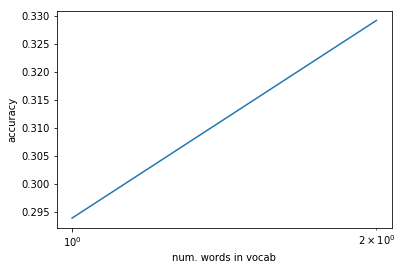

In [149]:
plt.plot([w[0] for w in curve_data], [w[1] for w in curve_data])
plt.xscale('log')
plt.xlabel('num. words in vocab')
plt.ylabel('accuracy')
plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
plt.show()

## Subject ablation attack

In [ ]:
counts_list = []
top_k = 5
with open(ATTRS_TSV) as f:
    for line in f:
        line = line.strip()
        question_attrs, predicted_answer, correct_answer, is_correct, image_id = line.split('\t')
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split(','):
            if len(word_attr.split('|')) < 2:
                print('skipped')
                continue
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(float(attr))
        k = min(top_k, len(question_tokens))
        counts_list.extend([question_tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

In [ ]:
unattributed_words = set(vocab_json['question'].keys()) - set(counts_list)

In [ ]:
unattributed_words

In [ ]:
list(unattributed_words)[-10:]

In [ ]:
nlp = spacy.load('en')
sent = "how symmetrical are the white bricks on either side of the building"
doc=nlp(sent)

sub_toks = [tok for tok in doc if (tok.dep_ == "nobj") ]

print(sub_toks)

In [ ]:
[d.dep_ for d in doc]

In [ ]:
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
net.eval()
answ = []
idxs = []
accs = []
num_iters = 0
batch_id = 0
attrs_tsv_string = ''
for v, q, a, idx, q_len in tq:
        
        var_params = {
            'volatile': False,
            'requires_grad': False,        
        }
        out_string = ''
        for i in range(config.batch_size):
            if len(np.nonzero(a[i, :] >= 3))==0:
                continue
            answers = [reverse_vocab_answer[int(w)] for w in np.nonzero(a[i, :] >= 3)]
            if 'yes' in answers or 'no' in answers:
                continue
            string_question = [reverse_vocab_question[int(w)] if int(w) != 0 else '' for w in q[i, :]]
            out_string += '-'*50 + '\n'
            out_string += 'orig: ' + ' '.join(string_question) + '\n'
            out_string += 'answers: ' + ' '.join(answers) + '\n'
            doc = nlp(' '.join(string_question))
            pos_tags = [d.dep_ for d in doc]
            #print(pos_tags)
            subject_index = [i for i, t in enumerate(pos_tags) if 'nsubj' in t]
            if len(subject_index) == 0:
                continue
            q[i, subject_index[0]] = vocab_json['question']['civilian']
            string_question = [reverse_vocab_question[int(w)] if int(w) != 0 else '' for w in q[i, :]]
            out_string += 'ablated: ' + ' '.join(string_question) + '\n'

            
        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)
        
        q_emb = embedding(q)
        
        out = net(v, q_emb, q_len)            
        
        acc = utils.batch_accuracy(out.data, a.data).cpu()
        
        _, answer = out.data.cpu().max(dim=1)
        
#        attrs_tsv_string = compute_attributions(q_emb, q_len, v, idx, num_batches=5)
        
#        outf.write(attrs_tsv_string)
        #for i in range(config.batch_size):
            #if int(acc[i]) >= 1.0:
                #print(out_string)
        
        answ.append(answer.view(-1))
        accs.append(acc.view(-1))
        idxs.append(idx.view(-1).clone())
        print(acc.mean())
        num_iters += 1
        batch_id += 1
        #print(' '.join([reverse_vocab_question[int(w)] for w in q[3,:] if int(w)!=0]))
        #print(acc[3])
        if num_iters == 5:
            break
            
#outf.close()

answ = list(torch.cat(answ, dim=0))
accs = list(torch.cat(accs, dim=0))
idxs = list(torch.cat(idxs, dim=0))

print('final: ' + str(np.mean(accs)))

In [ ]:
reverse_vocab_answer[int(np.nonzero(a[0, :] > 3))]

In [ ]:
np.nonzero(a[i, :] >= 3)

## Image specific bias

In [ ]:
import json
import scipy.stats as stats
from collections import Counter

In [ ]:
json_data=open('/scratch/pramodkm/vqa/data_vqa1.0/OpenEnded_mscoco_val2014_questions.json').read()
data = json.loads(json_data)

In [ ]:
data['questions']

In [ ]:
json_data=open('/scratch/pramodkm/vqa/data_vqa1.0/mscoco_val2014_annotations.json').read()
annot_data = json.loads(json_data)

In [ ]:
annot_data['annotations']

In [ ]:
image_ans = dict()
for ans_annot in annot_data['annotations']:
    turk_answers = [ans['answer'] for ans in ans_annot['answers']]
    if ans_annot['image_id'] not in image_ans:
        image_ans[ans_annot['image_id']] = [turk_answers]
    else:
        image_ans[ans_annot['image_id']].append(turk_answers)

In [ ]:
image_ans

In [ ]:
def visualize_baseline_answers(tokens, attrs, image_ans):
    html_text = ""
    count = 0
    for i, tok in enumerate(tokens):
        r,g,b = get_color(attrs[i])
        val = []
        for ans in image_ans:
            val += [sum(tok == np.array(ans))]
        if sum(np.array(val)>=3)>0:
            tok = '<u>' + tok + '</u>'
            count += 1
        html_text += "<span style='size:16;color:rgb(%d,%d,%d)'>%s</span>, " % (r, g, b, tok)
    return html_text, count

In [ ]:
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
net.eval()
answ = []
idxs = []
accs = []
num_iters = 0
batch_id = 0
outf = open('/scratch/pramodkm/vqa/tsv/baseline_answers.html','w')
html_str = '<html><head><link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous"></head>'
html_str += '<body><div class="container"> <h3> Top 15 answer classes for each image </h3><br>Generated by passing an empty question to the network. Underlined classes appear as answers to questions on the image. <br>'
html_str += '<table class="table">'
outf.write(html_str)

question = 'what color besides blue is there'
question_tokens = torch.LongTensor([vocab_json['question'][w] for w in question.strip().split()] + [0]*(23-len(question.strip().split())))
question_tokens = question_tokens.unsqueeze(0).repeat(config.batch_size,1)
new_q_len = torch.LongTensor([len(question.strip().split())])
new_q_len = new_q_len.repeat(config.batch_size)

covered_image_ids = set()

avg_count = []
for v, q, a, idx, q_len in tq:
        
        var_params = {
            'volatile': False,
            'requires_grad': False,        
        }
        
        q = question_tokens
            
        q_len = new_q_len
        
        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)
        
        q_emb = embedding(q)
                
        out = net(v, q_emb, q_len)    
        
        softmax = torch.nn.functional.softmax(out)
        
        acc = utils.batch_accuracy(out.data, a.data).cpu()
        
        _, answer = out.data.cpu().max(dim=1)

        # for baseline answers
        baseline_q = q * 0   
            
        baseline_q_len = q_len/q_len
        
        baseline_q_emb = embedding(baseline_q)
                
        baseline_out = net(v, baseline_q_emb, baseline_q_len)    
        
        baseline_softmax = torch.nn.functional.softmax(baseline_out)


        for batch_i in range(config.batch_size):
            baseline_probs, baseline_idxs = baseline_softmax[batch_i, :].sort(descending=True)
            baseline_answers = [reverse_vocab_answer[int(ix)] for ix in baseline_idxs]
            
            baseline_probs = [float(prob) for prob in baseline_probs]
            print_k = 15
            #outf.write('... ' + visualize_baseline_answers(baseline_answers[-10:], baseline_probs[-10:]))
            image_id = str(val_loader.dataset.coco_ids[int(idx[batch_i])])
            if image_id in covered_image_ids:
                continue
            covered_image_ids.add(image_id)
            #outf.write('<br>Question: ' + ' '.join([reverse_vocab_question[int(w)] for w in q[batch_i, :] if int(w)!=0]))
            #outf.write('<br>Pred. ans.: ' + reverse_vocab_answer[answer[batch_i]])
            outf.write('<br><tr><td><img src="val2014/COCO_val2014_' + '0'*(12 - len(str(image_id))) + str(image_id) + '.jpg" width="256" height="256"></img></td>')
            vis_string, count = visualize_baseline_answers(baseline_answers[:print_k], baseline_probs[:print_k], image_ans[int(image_id)])
            avg_count.append(count)
            outf.write('<td>' + vis_string + '<br> #classes appearing as answers: ' + str(count) + '</td></tr>')
            
            outf.write('<hr>')
                
        answ.append(answer.view(-1))
        accs.append(acc.view(-1))
        idxs.append(idx.view(-1).clone())
        num_iters += 1
        batch_id += 1
        if num_iters == 1:
            break
            
outf.write('</table></div></body></html>')
outf.close()

print(np.mean(avg_count))
answ = list(torch.cat(answ, dim=0))
accs = list(torch.cat(accs, dim=0))
idxs = list(torch.cat(idxs, dim=0))

In [ ]:
vocab_json['answer']['wood']

In [ ]:
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
net.eval()
answ = []
idxs = []
accs = []
num_iters = 0
batch_id = 0
outf = open('/scratch/pramodkm/vqa/tsv/baseline_answers.html','w')
html_str = '<head><link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous"></head>'
html_str += '<body><div class="container"> '
outf.write(html_str)

question = 'how many are not'
question_tokens = torch.LongTensor([vocab_json['question'][w] for w in question.strip().split()] + [0]*(23-len(question.strip().split())))
question_tokens = question_tokens.unsqueeze(0).repeat(config.batch_size,1)
new_q_len = torch.LongTensor([len(question.strip().split())])
new_q_len = new_q_len.repeat(config.batch_size)

batch_percentages = np.zeros(3000)
for v, q, a, idx, q_len in tq:
        
        var_params = {
            'volatile': False,
            'requires_grad': False,        
        }
                
        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        question_tokens = Variable(question_tokens.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)
        new_q_len = Variable(new_q_len.cuda(async=True), **var_params)
        
        
        # for baseline answers
        baseline_q = q * 0   
            
        baseline_q_len = q_len/q_len
        
        baseline_q_emb = embedding(baseline_q)
                
        baseline_out = net(v, baseline_q_emb, baseline_q_len)    
        
        baseline_softmax = torch.nn.functional.softmax(baseline_out)

        
        test_k = 300          
        test_q = question_tokens


        batch_baseline_answers = []
        for batch_i in range(config.batch_size):
            baseline_probs, baseline_idxs = baseline_softmax[batch_i, :].sort(descending=True)
            baseline_answers = [reverse_vocab_answer[int(ix)] for ix in baseline_idxs]
            
            counter = 4
            for ba in baseline_answers[2:]:
                if counter == 7:
                    break
                if ba not in vocab_json['question']:
                    continue
                test_q[batch_i, counter] = vocab_json['question'][ba]
                counter += 1
            test_out = net(v, embedding(test_q), new_q_len)
            _, answer = test_out.data.cpu().max(dim=1)

        for batch_i in range(config.batch_size):
            baseline_probs, baseline_idxs = baseline_softmax[batch_i, :].sort(descending=True)
            baseline_answers = [reverse_vocab_answer[int(ix)] for ix in baseline_idxs]
            
            baseline_probs = [float(prob) for prob in baseline_probs]
            print_k = 100
            outf.write(visualize_baseline_answers(baseline_answers[:print_k], baseline_probs[:print_k]))
            outf.write('... ' + visualize_baseline_answers(baseline_answers[-10:], baseline_probs[-10:]))
            image_id = str(val_loader.dataset.coco_ids[int(idx[batch_i])])
            outf.write('<br>Question: ' + ' '.join([reverse_vocab_question[int(w)] for w in test_q[batch_i, :] if int(w)!=0]))
            outf.write('<br>Pred. ans.: ' + reverse_vocab_answer[answer[batch_i]])
            outf.write('<br><img src="val2014/COCO_val2014_' + '0'*(12 - len(str(image_id))) + str(image_id) + '.jpg" width="256" height="256"></img><br><br>')
            outf.write('<hr>')
                      
        

        answ.append(answer.view(-1))
        accs.append(acc.view(-1))
        idxs.append(idx.view(-1).clone())
        num_iters += 1
        batch_id += 1
        if num_iters == 1:
            break
            
outf.write('</div></body>')
outf.close()
answ = list(torch.cat(answ, dim=0))
accs = list(torch.cat(accs, dim=0))
idxs = list(torch.cat(idxs, dim=0))

In [ ]:
plt.plot(batch_percentages[:300]/300)

In [ ]:
batch_percentages/300

In [ ]:
vocab_json['question']['rooster']

In [ ]:
set(vocab_json['question'].keys()) - set(vocab_json['answer'].keys())